Idea here is to make a 2 param NN (x,y,loss), then do a grid search where we init model, do one epoch, record results. Then contour it.

So first I need something to convert it to features.... then I have a linear(3) convert 3 features to one thing...

In [67]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm
%pylab inline
import pickle
import itertools
import datetime

Populating the interactive namespace from numpy and matplotlib


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [68]:
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [69]:
cuda=False
seed=0
batch_size=512


ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

model_path = 'data/model_%s.pickle' % ts
points_file = 'data/points_%s.pickle' % ts


torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Model

In [426]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=28, stride=(28,28))
#         self.conv2 = nn.Conv2d(10, 2, kernel_size=5)
#         self.fc1 = nn.Linear(320, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 2)
#         x = F.tanh(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-3)


In [204]:
# nn.Conv2d?

# Pretrain

In [205]:
# I got from 0.7 to 0.4 in 100 epochs
epochs=200
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        # reduce this to a binary problem
        target = (target>5).type(torch.FloatTensor)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.data[0]))

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [11232/60000 (99%)]	Loss: 0.636986
Train Epoch: 2 [11232/60000 (99%)]	Loss: 0.622902
Train Epoch: 3 [11232/60000 (99%)]	Loss: 0.602751
Train Epoch: 4 [11232/60000 (99%)]	Loss: 0.579772
Train Epoch: 5 [11232/60000 (99%)]	Loss: 0.581861


KeyboardInterrupt: 

In [425]:
minima = model.fc2.weight.data.numpy()
minima_z = loss.data.numpy()[0]
minima, minima_z

(array([[ 0.22772104,  0.45285982]], dtype=float32), 5.7115297)

In [427]:

torch.save(model, model_path)

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Explore

In [428]:
model2 = torch.load(model_path)
# freeze all except last layer
mlayers = [
    model2.conv1,
#     model2.conv2,
#     model2.fc1
]
for layer in mlayers:
    for param in layer.parameters():
          param.requires_grad = False

In [429]:
model2.fc2.weight.data.size()

torch.Size([1, 2])

In [430]:
xm, ym = torch.Tensor(minima.T)
xm, ym = xm.numpy()[0], ym.numpy()[0]

In [431]:
xs=torch.arange(xm-40,xm+0,0.3)
# xs = torch.Tensor(np.sort(np.random.normal(xm,100,100)))
ys=torch.arange(ym-40,xm+40,0.3)
# ys = torch.Tensor(np.sort(np.random.normal(ym,100,100)))
xys = list(itertools.product(xs,ys))

In [434]:
xs=torch.arange(xm-20,xm+20,1)
# xs = torch.Tensor(np.sort(np.random.normal(xm,100,100)))
ys=torch.arange(ym-20,xm+20,1)
# ys = torch.Tensor(np.sort(np.random.normal(ym,100,100)))
xys = list(itertools.product(xs,ys))

In [ ]:
# grid search, run this overnight
points = []

for x,y in tqdm(xys):
    
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    # set last layer weights
    model2.fc2.weight.data =  torch.Tensor([[y,x]])

    zs=[]
    dzs=[]
    batches=0

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # reduce this to a binary problem
        target = (target>5).type(torch.FloatTensor)

        optimizer.zero_grad()
        output = model2(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        dzs.append(model2.fc2.weight.grad.data.numpy())
        zs.append(loss.data.numpy()[0])
        batches += 1 
        
        if batches>6:
            break
            
    output = model2(data)
    loss = F.binary_cross_entropy(output, target)

    z = np.mean(zs)
    z_var = np.std(zs)
    dz = np.mean(dzs,0)
    dz_var = np.std(dzs,0)
    points.append([x,y,z, z_var, dz, dz_var, batches])

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [415]:
x = np.array([p[0] for p in points])
y = np.array([p[1] for p in points])
z = np.array([p[2] for p in points])
zv = np.array([p[3] for p in points])
dz = np.array([p[4] for p in points])[:,0,:]
dzv = np.array([p[5] for p in points])[:,0,:]

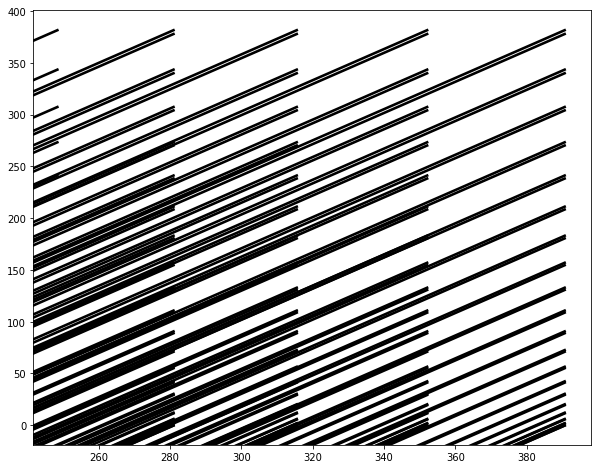

In [416]:
plt.figure(figsize=(10,8))
# x,y,z,zv,dz,dzv, n = np.array(points).T
plt.quiver(x, y, dz[:,0], dz[:,1], angles='xy', scale_units='xy', scale=1)
plt.show()

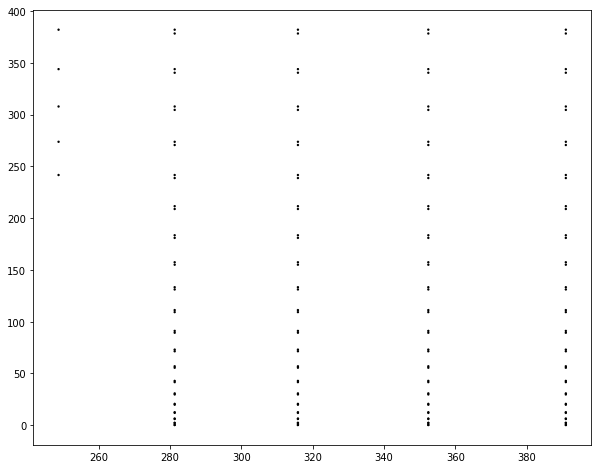

In [417]:
plt.figure(figsize=(10,8))
# x,y,z,zv,dz,dzv, n = np.array(points).T
plt.quiver(x, y, dzv[:,0], dzv[:,1], angles='xy', scale_units='xy', scale=1)
plt.show()

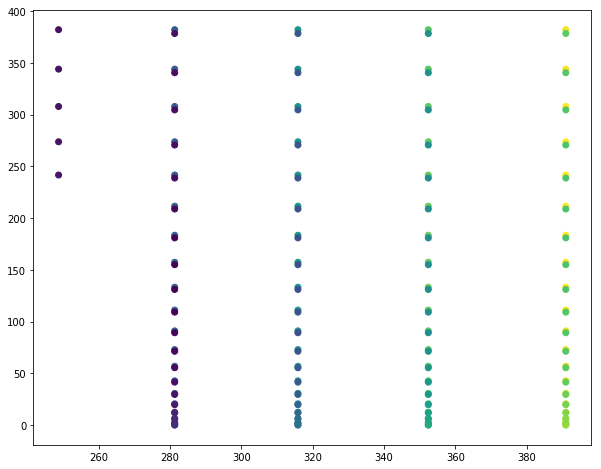

In [418]:
plt.figure(figsize=(10,8))
# x,y,z,zv,dz,dzv, n = np.array(points).T
plt.scatter(x,y,c=dz[:,0])
plt.show()

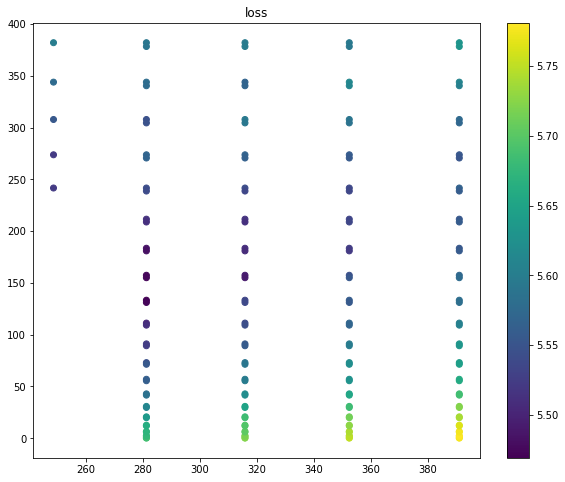

In [419]:
plt.figure(figsize=(10,8))
plt.scatter(x,y,c=z)
plt.title('loss')
plt.colorbar()

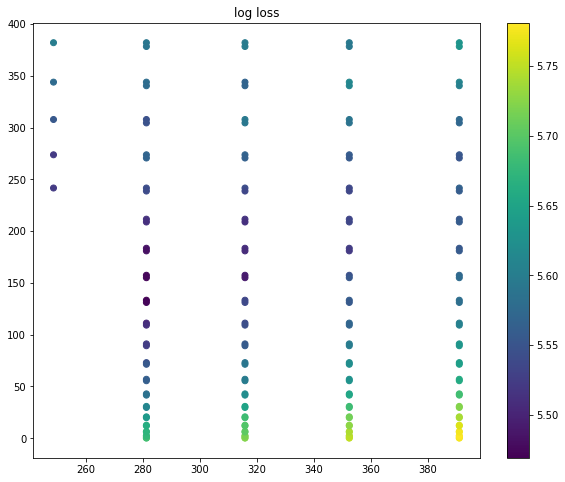

In [420]:
plt.figure(figsize=(10,8))
plt.scatter(x,y,c=z)
plt.title('log loss')
plt.colorbar()

ValueError: Invalid RGBA argument: -0.93098905452915248

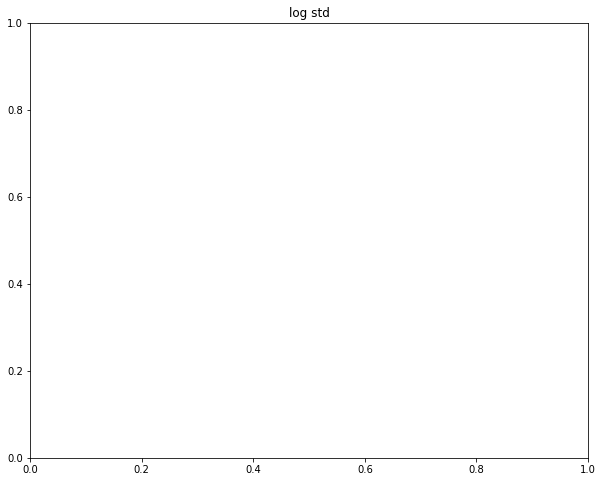

In [421]:
plt.figure(figsize=(10,8))
plt.title('log std')
plt.scatter(x,y,c=np.log(v))
plt.colorbar()

ValueError: Invalid RGBA argument: 0.39416366815567017

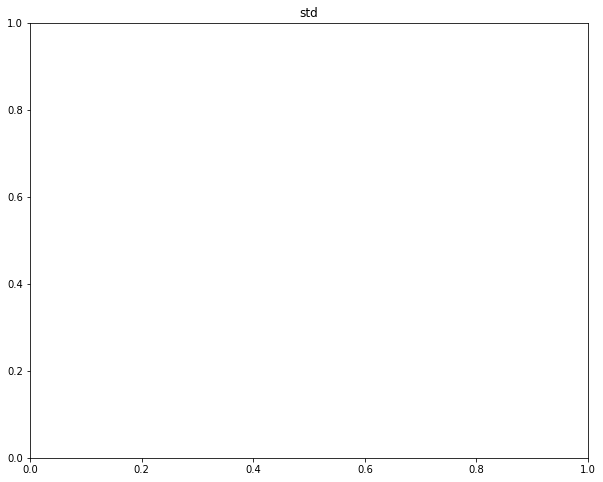

In [422]:
plt.figure(figsize=(10,8))
plt.title('std')
plt.scatter(x,y,c=v)
plt.colorbar()

In [348]:
# save
pickle.dump('points267x266', open(points_file,'wb'))

In [328]:
# save

pickle.dump(points, open(points_file,'wb'))

In [78]:
# save
points = pickle.load(open(points_file,'rb'))

In [346]:

x,y,z,v,n = np.array(points).T

# scale lossses to they look OK
z=(z-z.min())*10000000
logzmax = np.log(z.max())
logzmax

19.090419312520552

In [349]:
# now reshape into square arrays
x = x.reshape((len(xs),len(ys)))
y = y.reshape((len(xs),len(ys)))
z = z.reshape((len(xs),len(ys)))
# dz = dz.reshape((len(xs),len(ys)))
v = v.reshape((len(xs),len(ys)))
# dzv = dzv.reshape((len(xs),len(ys)))
z.shape

(267, 266)

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


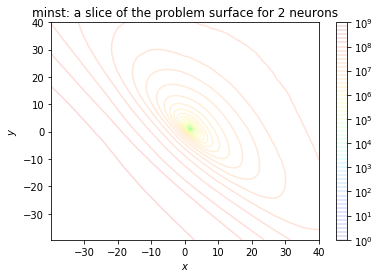

In [345]:
ax = plt.gca()
cm=ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 55), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
# ax.plot(*minima_, 'r*', markersize=10)
# ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('minst: a slice of the problem surface for 2 neurons: loss')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

In [351]:
# scale lossses to they look OK
v=(v-v.min())*10000000
logvmax = np.log(v.max())
logvmax

15.494302237578435

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


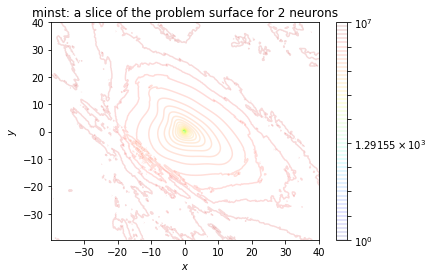

In [352]:
ax = plt.gca()
cm=ax.contour(x, y, v, levels=np.logspace(0, logvmax//2, 55), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
# ax.plot(*minima_, 'r*', markersize=10)
# ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('minst: a slice of the problem surface for 2 neurons - variance')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

# Generate path

In [ ]:
model3 = torch.load(model_path)
# freeze all except last layer
mlayers = [
    model3.conv1,
    model3.conv2,
    model3.fc1
]
for layer in mlayers:
    for param in layer.parameters():
          param.requires_grad = False
            
optimizer = optim.SGD(model3.parameters(), lr=1e-3)

In [ ]:
epochs=100
points2=[]
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        # reduce this to a binary problem
        target = (target>5).type(torch.FloatTensor)
        
        optimizer.zero_grad()
        output = model3(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        x,y=model3.conv2.weights.data
        z=loss.data
        points2.append([x,y,z])
    
    
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.data[0]))